# Import modules

In [1]:
import math
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import dataretrieval.nwis as nwis
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/shoal_densified.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Sub-models')

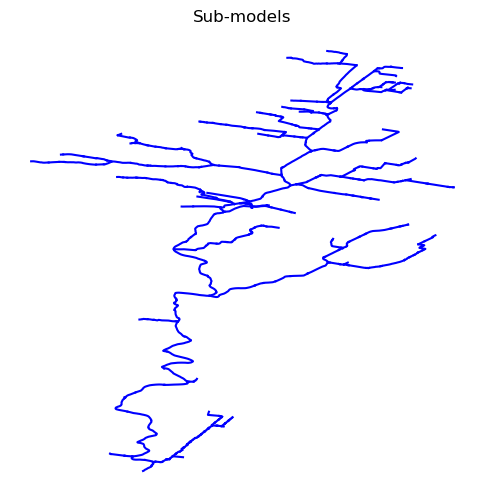

In [3]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c='b')
plt.axis('off')
plt.title('Sub-models')

# Create model inputs

### Load NWM forcings

In [4]:
key = 'no_data_assimilation'#'short_range'#
# Define path for NWM forcings
forcing_path = '../data/20240122_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20240121', '20240124', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key=key+'__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key=key+'__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key=key+'__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
## Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Create inputs to model based on forcings

In [5]:
# Create input table with lateral overflow into each modeled reach
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
input_index = forcing.index.copy()
inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

# Fill input table with forcings for each reach
store = pd.HDFStore('../data/area_fractions.h5', 'r')
hdf_keys = store.keys()
store.close()
for key in hdf_keys:
    comid = key.split('__')[-1]
    area_ratios = pd.read_hdf(f'../data/area_fractions.h5', key=key)
    for reach_id in area_ratios.index:
        if comid in forcing.columns:
            runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
            reach_id_str = str(reach_id)
            if reach_id_str in inputs.columns:
                inputs[reach_id_str] += runoff_proportion
# NOT NEEDED FOR SHOAL AND WALLER CREEK AREAS -- NO UPSTREAM INPUTS 
# Add inflow to upstream boundary reaches
#upstream_inputs = {
#    '5779305' : '5781161',
#    '5785187' : '5785899',
#    '5786029' : '5785351'
#}
#for downstream_reach, upstream_reach in upstream_inputs.items():
#    inputs[downstream_reach] += streamflow[upstream_reach]

In [6]:
# Resample forcing input table to frequency of model timestep
dt = model_collection.timedelta.seconds
inputs = inputs.resample(f'{dt}s').mean()
inputs = inputs.interpolate().bfill().ffill()
assert not inputs.isnull().any().any()

In [7]:
len(input_columns)

574

# Gather gage measurements for event period

In [8]:
# Load table of mappings from USGS Gage IDs to NWM COMIDs
usgs_to_densified_reach_df = pd.read_csv('../data/NWPSGagesTravis_All_Join_to_Densified.csv', index_col=0) [['usgs_id','creek_id']]
# print(usgs_to_densified_reach_df.columns)
usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','creek_id']].reset_index(drop=True).dropna().reset_index(drop=True)
usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['creek_id'].astype(int).astype(str)
# Filter 
usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]

##  retrieve from usgs

In [9]:
usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)

In [10]:
# Load table of USGS gage measurements
measurements = pd.read_hdf('../data/gages.h5', key='usgs') #pd.read_hdf('../data/gages_usgs_20240121_to_20240124.h5', key='usgs')
measurements.columns = measurements.columns.astype(int).astype(str) # 596 gages 2020-2024-7
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach) # change the column to COMID
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]] 
#select the right time period as the forcing
measurements = measurements.dropna(axis=1) # drop gages without data
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]  # 36 gages
# drop gages where all flow are zeros
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill() 
measurements

,2360775,2382255
2024-01-21 00:00:00+00:00,0.002029,0.000000
2024-01-21 00:00:10+00:00,0.002029,0.000000
2024-01-21 00:00:20+00:00,0.002028,0.000000
2024-01-21 00:00:30+00:00,0.002027,0.000000
2024-01-21 00:00:40+00:00,0.002027,0.000000
...,...,...
2024-01-23 22:59:20+00:00,0.385266,0.209725
2024-01-23 22:59:30+00:00,0.385227,0.209644
2024-01-23 22:59:40+00:00,0.385188,0.209564
2024-01-23 22:59:50+00:00,0.385148,0.209483


# Set up Kalman Filter

In [11]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Prepare and simulate model

### Prepare model for simulation

In [12]:
# Add downstream boundaries to model
for model in model_collection.models.values():
    outlet = model.startnodes[model.startnodes == model.endnodes].item()
    model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

### Simulate model

In [13]:
starttime = datetime.datetime.now()
# Simulate models
outputs_da = await simulation.simulate()
endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")
# Collect outputs into a single table
outputs_da = pd.concat([series for series in outputs_da.values()], axis=1)

the code took 0:02:44.078653 to run


# Export peak flow

# Plot results

Text(0.5, 1.0, 'Shoal Model: Discharge response to storm event on 01/22/24')

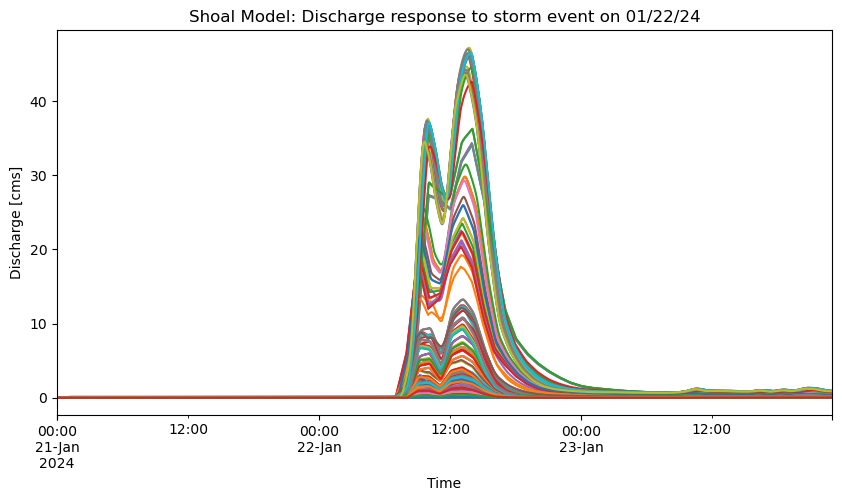

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

outputs_da.plot(ax=ax, legend=False)
plt.xlabel('Time')
plt.ylabel('Discharge [cms]')
plt.title('Shoal Model: Discharge response to storm event on 01/22/24')

# Compare results

### Run model without DA

In [15]:
# Define model file input path
#input_path = '../data/travis-county-lo-res-model-partitioned.json'  # defined earlier
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

# Add downstream boundaries to model
for model in model_collection.models.values():
    # change the timestep
    model.timedelta = pd.to_timedelta('120s')
    model.compute_muskingum_coeffs()
    #print(model.timedelta)

# Add downstream boundaries to model
for model in model_collection.models.values():
    if not model.sinks:
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

# Set starting time of each model to just before start of forcings
timedelta = pd.to_timedelta(dt, unit='s')
for model_name, model in model_collection.models.items():
    model.datetime = inputs.index[0] - timedelta

# Set up simulation
simulation = AsyncSimulation(model_collection, inputs)

starttime = datetime.datetime.now()

# Simulate models
outputs_noda = await simulation.simulate()
# Collect outputs into a single table
outputs_noda = pd.concat([series for series in outputs_noda.values()], axis=1)

endtime = datetime.datetime.now()
print(f"the code took {endtime-starttime} to run")

the code took 0:00:00.806607 to run


### Plot model result vs. KF vs. measurements at gage locations

### Plot map of gains

In [16]:
total_gain = (outputs_da - outputs_noda).mean(axis=0)

In [17]:
den_streams_tx = gpd.read_file('../data/travis_densified_streamlines')
den_streams_tx['reach_id'] = den_streams_tx['reach_id'].astype(int).astype(str)
den_streams_travis = den_streams_tx[den_streams_tx['reach_id'].isin(input_columns)].copy()
den_streams_travis['gain'] = den_streams_travis['reach_id'].map(total_gain).fillna(0.).values
den_streams_travis['log_gain'] = np.log(1 + np.abs(den_streams_travis['gain'].values))

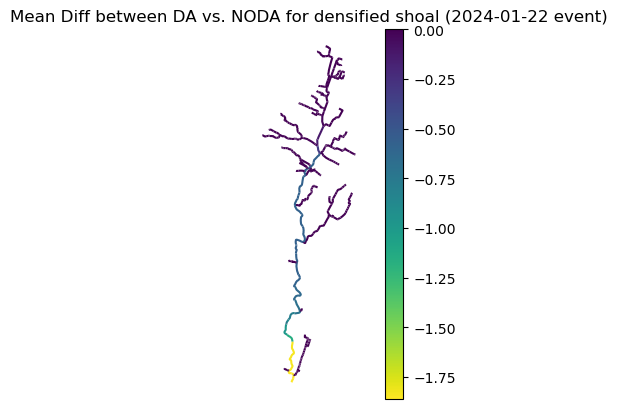

In [18]:
den_streams_travis.plot(column='gain', cmap='viridis_r', legend=True)
plt.title('Mean Diff between DA vs. NODA for densified shoal (2024-01-22 event)')
_ = plt.axis('off')

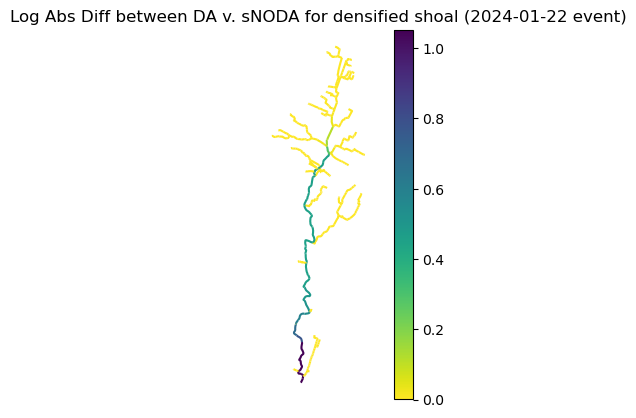

In [19]:
den_streams_travis.plot(column='log_gain', cmap='viridis_r', legend=True)
plt.title('Log Abs Diff between DA v. sNODA for densified shoal (2024-01-22 event)')
_ = plt.axis('off')

# Animation

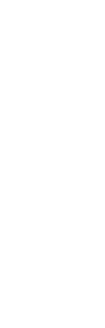

In [34]:
# Assuming nwm_streams_tx, model.reach_ids, and outputs are already defined
den_streams_tx = gpd.read_file('../data/travis_densified_streamlines')
den_streams_tx['reach_id'] = den_streams_tx['reach_id'].astype(int).astype(str)
den_streams_travis = den_streams_tx[den_streams_tx['reach_id'].isin(input_columns)].copy()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
plt.axis('off')

# Initialize the plot with empty data
plot = den_streams_travis.plot(ax=ax, color='b', zorder=3, linewidth=0)

"""
# Create legend for linewidths based on flow values
# Choose representative flow values (e.g., based on min, max, or quartiles of flow data)
flow_values = [0, 50, 100, 200, 500]  # Adjust these based on your data range
legend_lines = [Line2D([0], [0], color='b', lw=1 * np.log(1 + flow)) for flow in flow_values]
legend_labels = [f'Flow: {flow}' for flow in flow_values]
ax.legend(legend_lines, legend_labels, title='Discharge (cms)', loc='upper right')
"""

# Function to update the plot for each frame (timestep)
def update(frame):
    ax.clear()  # Clear the previous frame
    ax.axis('off') 
    plt.axis('off')  # Keep axis off
    # Get flow values for the current timestep (frame)
    den_streams_travis['flow'] = den_streams_travis['reach_id'].map(outputs_da.iloc[frame]).fillna(0.).clip(lower=0).values
    # Plot with linewidth scaled by log of flow
    den_streams_travis.plot(
        ax=ax, 
        color='b', 
        zorder=3, 
        linewidth=1 * np.log(1 + den_streams_travis['flow'].values)
    )
    # Update title with the current date
    ax.set_title(f'Discharge on {outputs_da.index[frame]}')
    # Re-add the legend to ensure it persists
    #ax.legend(legend_lines, legend_labels, title='Discharge (cms)', loc='upper right')
    # Force redraw of the figure to ensure title and legend are rendered
    fig.canvas.draw()
    return plot,

# Create animation
ani = FuncAnimation(
    fig, 
    update, 
    frames=range(0, len(outputs_da), 300),#len(outputs_noda),  #Number of timesteps
    interval=200,  # Delay between frames in milliseconds
    blit=False  # Set to False since GeoDataFrame plotting doesn't support blitting well
)

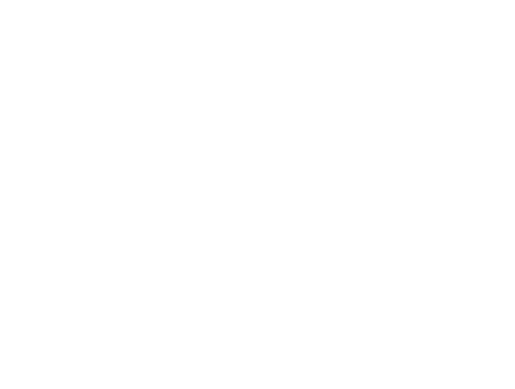

In [35]:
ani.save('../figure/shoal_anim_20240122_da.gif', writer='pillow', fps=5, dpi=600)